In [95]:
# @hide_cell
import pickle
import numpy as np
import pandas as pd
from typing import Iterable, Optional, Tuple, Any, List
from tqdm import tqdm_notebook as tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from darts import TimeSeries
from darts.utils.statistics import (
    check_seasonality,
    plot_acf,
    plot_pacf)
from darts.metrics import (
    mse,
    mape
)
import darts
from darts.models import (
    ARIMA,
    AutoARIMA,
    RNNModel,
    NBEATSModel,
    TCNModel
)
from darts.dataprocessing.pipeline import Pipeline
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.utils.likelihood_models import (
    GaussianLikelihood,
    QuantileRegression
)
from darts.utils.losses import SmapeLoss
from statsmodels.graphics import tsaplots as tsaplots
import pmdarima as pm
import torch
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    StandardScaler,
    QuantileTransformer,
    PowerTransformer
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error
)

import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns
import datetime as dt
import os
import warnings

plt.style.use("ggplot")
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")


%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%config Completer.use_jedi = False

In [96]:
ALPHA = 0.05  # significance level used on default
RND_STATE = 192837
PRED_TIME = dt.datetime(2013, 12, 31)
DATA_DIR = "../data"  # data folder
MODELS_DIR = "../models"  # models folder
DATA_EXT = os.path.join(DATA_DIR, "external")  # external data folder
DT_FORMAT = "%Y-%m-%d"

# Content
1. [Literature overview](#lit)
2. [Explorative data analysis](#eda)
3. [Data visualizations and explorations](#viz)
4. [Baseline: auto ARIMA](#arima)
5. [RNN approach](#rnn)
6. [N-BEATS model](#nbeats)
7. [Answer to tasks](#answ)


# <a id="lit"></a>
# 1. Literature overview

The overall methods applicable to timeseries (TS) forecasting could be divided into the following classes:

* statistical
* machine learning (ML)
* deep learning (DL)

According to the recent [findings](https://analyticsindiamag.com/top-time-series-model-state-of-the-art/) DL-based models performs well on time series-related tasks.
From my experience the data provided has small number of observations to plug it into the DL model for the model to have reasonable performance (i.e. to outperform ML- or statistical-based algorithms). But on the other hand, a transfer learning approach is showing reasonable results even at zero shots tasks. The state-of-the-art models are considered to be :
* [N-BEATS](https://openreview.net/pdf?id=r1ecqn4YwB): neural basis expansion analysis for interpretable time series forecasting
* [ES-RNN](https://www.researchgate.net/publication/334556784_A_hybrid_method_of_exponential_smoothing_and_recurrent_neural_networks_for_time_series_forecasting/link/5d40998992851cd04694ab68/download): hybrid method of exponential smoothing and recurrent neural networks for time series forecasting

Further, acc. to [top Kagglers' approaches](https://www.kaggle.com/code/ryanholbrook/hybrid-models) used in the TS competitions are as follows (for inspiration):

* [STL boosted with exponential smoothing](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8125) - Walmart Recruiting - Store Sales Forecasting
* [ARIMA and exponential smoothing boosted with GBDT](https://www.kaggle.com/c/rossmann-store-sales/discussion/17896) - Rossmann Store Sales
* [An ensemble of stacked and boosted hybrids](https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/39395) - Web Traffic Time Series Forecasting
* [Exponential smoothing stacked with LSTM neural net](https://github.com/Mcompetitions/M4-methods/blob/slaweks_ES-RNN/118%20-%20slaweks17/ES_RNN_SlawekSmyl.pdf) - M4 (non-Kaggle)

It can be seen that the approaches developed by kagglers are hybrid, i.e. they are combining different models (statistical, ML and DL as in ES-RNN approach), are using boosting or/and stacking, employ these models for different components of the TS ([TS decomposition](https://otexts.com/fpp2/decomposition.html)) and work exhaustively with feature engineering.

An extensive statistical methods overview is given by Rob J Hyndman and George Athanasopoulos in [Forecasting: Principles and Practice](https://otexts.com/fpp2/). An extensive librarbies that could be used to simplify some approaches implementation could be found [here](https://neptune.ai/blog/time-series-tools-packages-libraries).

As for the well known competitions and data sets, there are M3 and M4 competitions resulted in N-BEATS, ES-RNN winners.

Moreover, there's a very promising [Darts](https://unit8co.github.io/darts/index.html) library. It allows variety of methods to be applied from calssic statistics up to different DL architectures and transformers (event transfer learning from M3 and M4 datasets). It's definitely worth to employ it.

----
----


#### Conclusion from review:
Acc. to the task the number of models to be implemented is >= 2 and as I'm applying to a position which requires MLOps experience I'll implement some baseline then will try to improve it, and then add some automation and experiment setup.
As Darts lib did not exist last time I was dealing with TS, so first I'm going to apply some classical approach, and then I'll go for the Darts implementation.

The following plan is to:
* make an EDA (classical tools and libs)
* implement some naive baseline
* try some XGB/DL model (probably Darts-based framework)
* automate experiment with some pipeline and experiment tracker (Darts-based + MLFlow)
* build some simple Dash app or REST API on the top of it

# <a id="eda"></a>
# 2. EDA

In [97]:
# Function definition.
def go_plot(traces: list, title: str = "", x_axis: str = None, y_axis: str = None):
    figure = go.Figure(
            data=traces,
            layout=go.Layout({
                "title": str(title),
                "xaxis": dict(title_text=x_axis),
                "yaxis": dict(title_text=y_axis),
                "template": "ggplot2"}))
    figure.show()

In [98]:
data = pd.read_csv(os.path.join(DATA_DIR, "raw", "DTSE_AIS_unemployment_task_data.csv"))
print(f"Data shape is {data.shape}")
data.sample(4)

Data shape is (203, 5)


,Period,realgdp,pop,unemp,infl
34,1967-07-01,3950.826,199.311,3.8,3.58
16,1963-01-01,3141.087,188.580,5.8,0.53
5,1960-04-01,2834.390,180.671,5.2,0.14
194,2007-07-01,13321.109,302.509,4.7,3.45


In [99]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
realgdp,203.0,7221.171901,3214.956044,2710.349,4440.1035,6559.594,9629.3465,13415.266
pop,203.0,239.724153,37.390450,177.146,208.6310,236.348,271.7215,308.013
unemp,202.0,5.980198,1.634152,3.400,5.0000,5.700,6.9000,15.900
infl,203.0,3.961330,3.253216,-8.790,2.2700,3.240,4.9750,14.620


* it's already seen that there's at least one Nan value in "unemp" column.
* "unemp" column is pretty tight spread around mean
* number of observations is pretty small, though enough to solve the task

### Data cleaning: types, outliers, nans, etc.

#### Data types

In [100]:
#@hide_cell
data.dtypes

Period      object
realgdp    float64
pop        float64
unemp      float64
infl       float64
dtype: object

In [101]:
#@hide_cell
data.Period = data.Period.apply(
    lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))

In [102]:
# Set index to be a Period of timestamp type for easier further data slices.
data.set_index("Period", inplace=True)

#### Nans

In [103]:
# @hide_cell
data.isna().any()

realgdp    False
pop        False
unemp       True
infl       False
dtype: bool

In [104]:
index = data.loc[data.unemp.isna()].index[0]
data.loc[data.unemp.isna()]

,realgdp,pop,unemp,infl
Period,,,,
2000-01-01,11043.044,281.653,NaN,3.76


In [105]:
trace = go.Scatter(x=data.index, y=data.unemp)
go_plot([trace], x_axis="Time [3M]",
        y_axis="Unemployment [%]",
        title="Unemployment Nan values")

As it's seen that 2000 year point was artificially removed for the data
I would simply impute it by linear interpolation.

In [106]:
data.loc[index, "unemp"] = data.unemp.interpolate()[index]
assert data.isna().any().any() == False

#### Outliers

In [107]:
fig = make_subplots(specs=[[{"secondary_y": True}]], shared_xaxes=True)
fig.layout.update({
    "title": "Outliers visualization",
    "template": "ggplot2",
    "xaxis_title": "Time [3M]",
    "yaxis_title": "[USD] / [%]",
})
left_cols = ["realgdp", "pop"]
for col in left_cols:
    trace = go.Scatter(x=data.index, y=data[col], name=col)
    trace_rolling = go.Scatter(x=data.index, y=data[col], name=col)
    fig.add_trace(trace)
for col in [c for c in data.columns if c not in left_cols]:
    trace = go.Scatter(x=data.index, y=data[col], name=col)
    fig.add_trace(trace, secondary_y=True)
fig.show()

#### As there are some outliers, so I'll apply simple smoothing filter to identify them

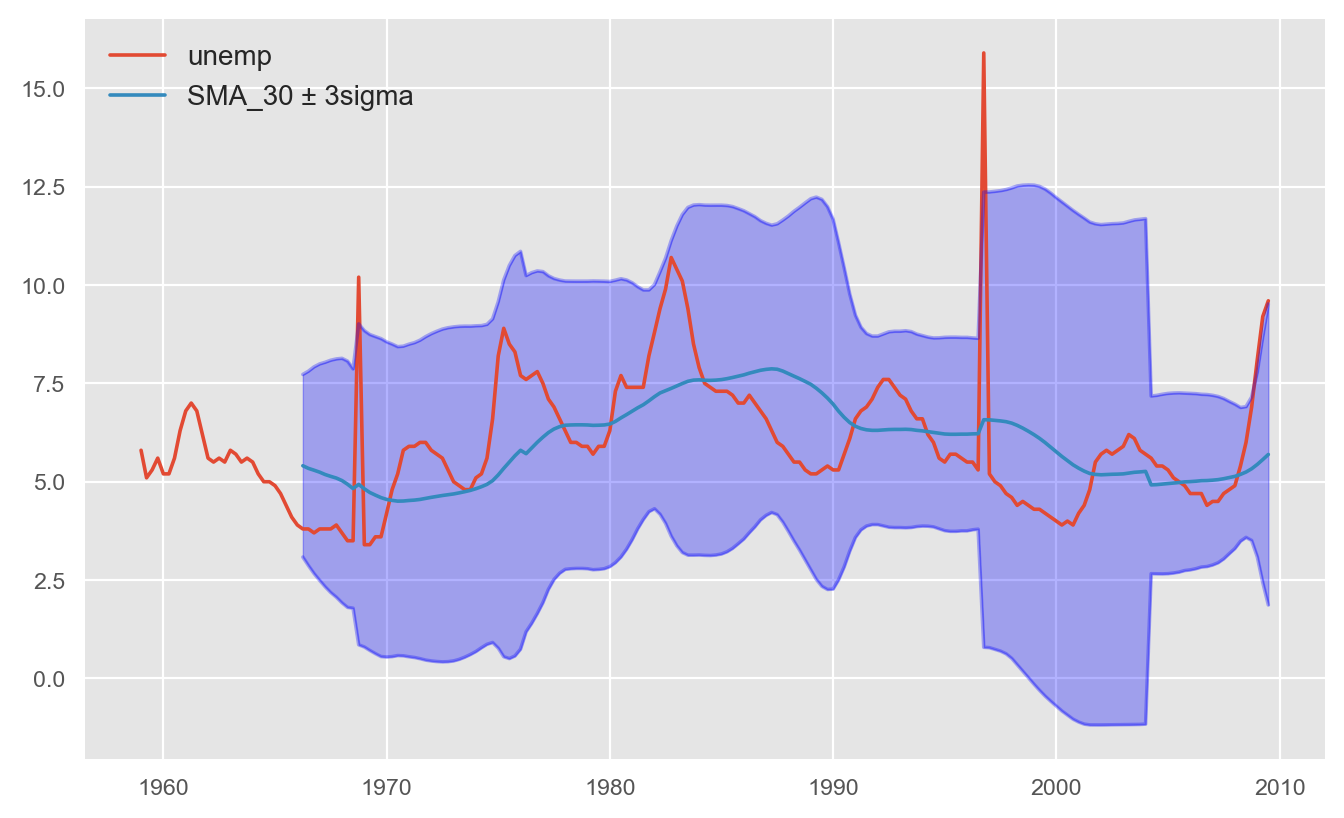

In [108]:
col = "unemp"
n = 30
n_sigma = 3
scale = 0.8
plt.figure(figsize=(np.array([10, 6]) * scale))
rolling_mean = data[col].rolling(n).mean()
rolling_std = data[col].rolling(n).std()
upper, lower = rolling_mean + n_sigma * rolling_std, rolling_mean - n_sigma * rolling_std
plt.plot(data.index, data[col], label=col)
plt.plot(rolling_mean.index, rolling_mean, label=f"SMA_{n} ± {n_sigma}sigma")
plt.plot(rolling_mean.index, upper, c="b", alpha=0.3)
plt.plot(rolling_mean.index, lower, c="b", alpha=0.3)
plt.fill_between(data.index, upper, lower, color="b", alpha=0.3)
plt.legend();

Let's check the outliers in the table view.

In [109]:
data.loc[(data.unemp > upper) | (data.unemp < lower)]

,realgdp,pop,unemp,infl
Period,,,,
1968-10-01,4178.293,201.760,10.2,4.51
1996-10-01,9592.458,271.360,15.9,3.02
2009-01-01,12925.410,306.547,8.1,0.94
2009-04-01,12901.504,307.226,9.2,3.37
2009-07-01,12990.341,308.013,9.6,3.56


As there are 2 outliers out of 3*sigma deviation in 1968 and 1996 respectively,
I would interpolate them (looks like they were introduced artificially to the data).

Regarding 2009's spike I would leave it as is for now, as it seems to correspond to crisis, however I'll think if I need to have it in the test/validation sample.


In [110]:
# Get indexes of the outliers.
mask = data.loc[
    ((data.unemp > upper) | (data.unemp < lower)) &
    (data.index.year < 2009)].index
# Interpolate those outliers.
data.loc[mask, "unemp"] = np.nan
data.loc[mask, "unemp"] = data.unemp.interpolate()

As I'm going to use Darts for further data investigation, so I convert it into Timeseries type.

In [111]:
y = data.loc[:, ["unemp"]]
series = TimeSeries.from_dataframe(y)

# <a id="viz"></a>
# 3. Data visualizations and explorations

#### Data overview

In [112]:
fig = make_subplots(specs=[[{"secondary_y": True}]], shared_xaxes=True)
fig.layout.update({
    "title": "All data overview",
    "template": "ggplot2",
    "xaxis_title": "Time [3M]",
    "yaxis_title": "[USD] / [%]",
})
left_cols = ["realgdp", "pop"]
for col in left_cols:
    trace = go.Scatter(x=data.index, y=data[col], name=col)
    trace_rolling = go.Scatter(x=data.index, y=data[col], name=col)
    fig.add_trace(trace)
for col in [c for c in data.columns if c not in left_cols]:
    trace = go.Scatter(x=data.index, y=data[col], name=col)
    fig.add_trace(trace, secondary_y=True)
fig.show()

In order to predict **number of unemployed people** in 2014 I would also need to predict population, but this seems to be pretty straightforward as it can be well described by linear function. I'll get back to predicting population at the very end.
Now I'll focus on the unemployment rate only.

#### Histplot

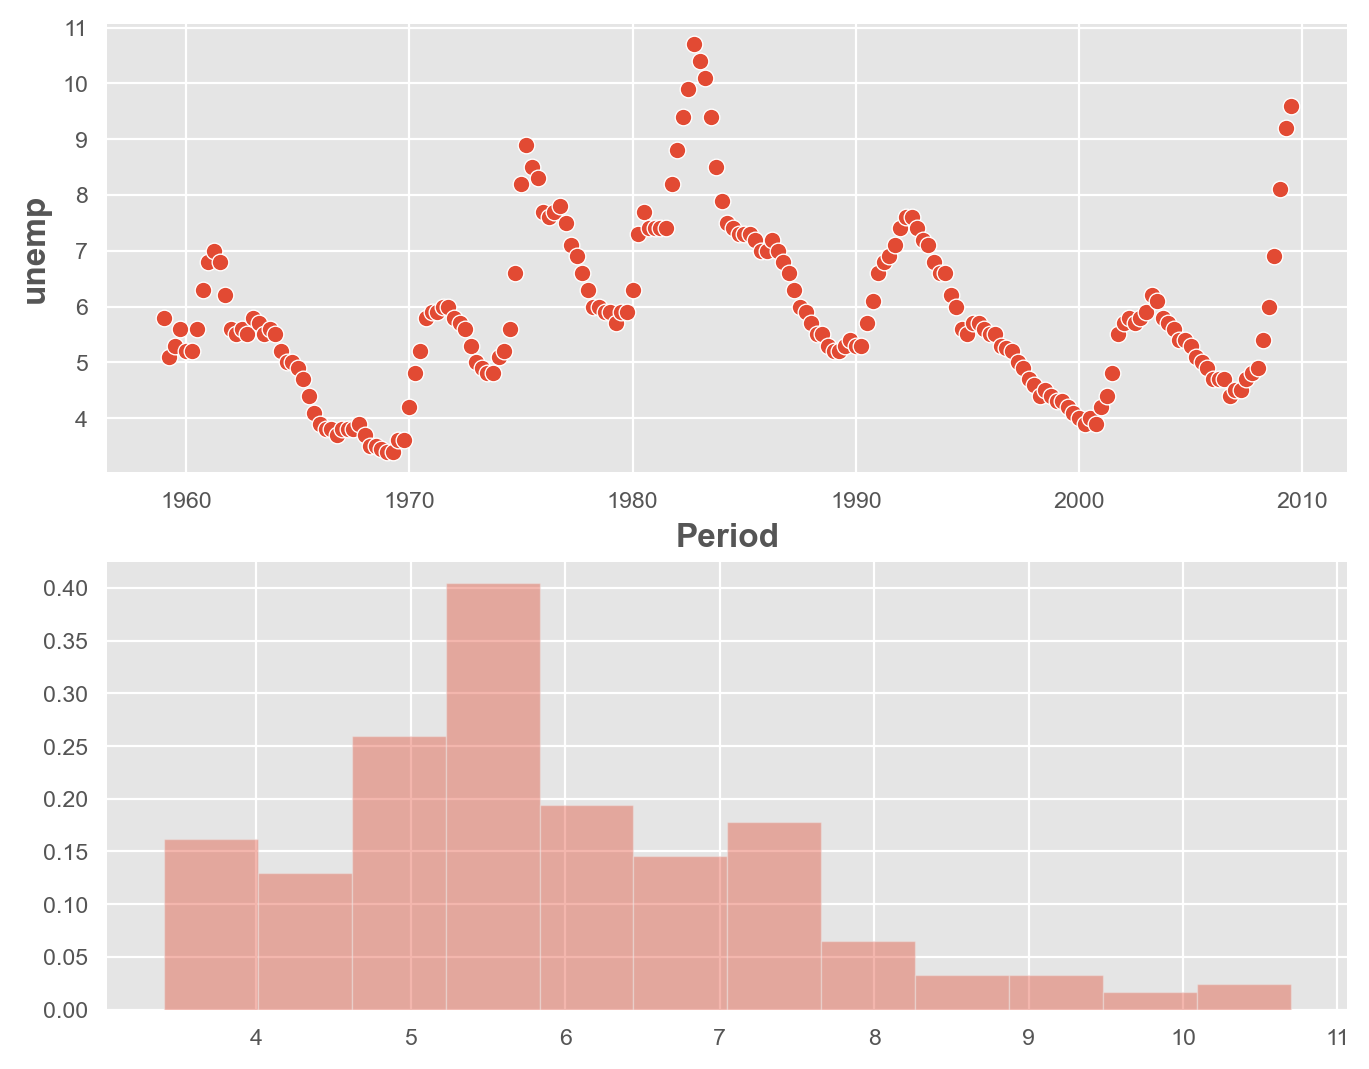

In [113]:
scale = 0.8
fig, axes = plt.subplots(2, 1, figsize=np.array([10, 8]) * scale)
sns.scatterplot(x=data.index, y=data.unemp, ax=axes[0])
sns.distplot(x=data.unemp, norm_hist=True, kde=False, ax=axes[1])
plt.show();

Takeaways from the graphs above:
* there is seasonality/cycling at several periods (corresponds to economy cycles), so it's changing over time
* some data skew can be seen from distribution graph (below), thus I might be using some transformation (Log, Box-Cox, etc.)

### Boxplot of aggregated unemployment data

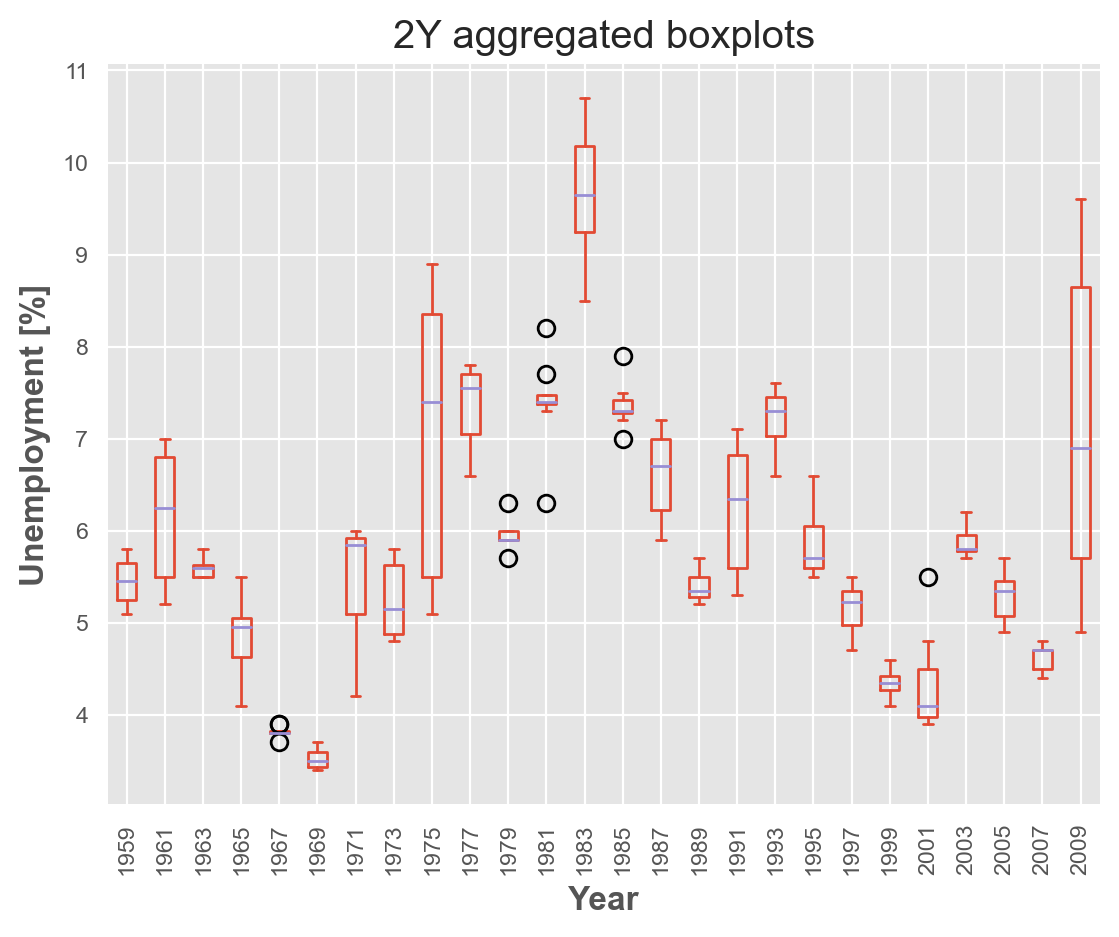

In [114]:
frequency = "2Y"
groups = data.resample(frequency)["unemp"]
years = {date: df for (date, df) in groups}
data_box = pd.DataFrame(years)
data_box.columns = [t.year for t in data_box.columns]
data_box.plot(kind="box");
plt.xticks(rotation=90)
plt.title(f"{frequency} aggregated boxplots")
plt.ylabel("Unemployment [%]")
plt.xlabel("Year");

As it's seen from the graph above it seems that some seasonality exists in unemployment.
This is in correspondence with economic cycles.
There might be a problem with ARIMA as the seasonality is of high order, i.e. around 20-30 years.
And ARIMA family models usually perform badly with such high seasonality.
<br>
Thus, it tells that TS is almost clearly non-stationary.
One can also observe increase in employment at 1983 -- the year of USA economy recession.
Next spike arises after 2007-2008 years of global financial crisis.

At this point I would introduce some baseline model, e.g. auto ARIMA.

#### Stationary checks for initial ARIMA params definition
I'll use augmented Dickey-Fuller test as one of the most widespread test for the purpose:
$H_0$ -- TS is __not__ stationary

In [115]:
col = "unemp"
significance = "5%"
diff = pd.DataFrame(data[col].diff().dropna(), columns=[col])
df_test = adfuller(diff[col].values)
print(f"Augmented Dickey-Fuller test statistic is: \n{df_test[0]:.2f}\n"
      "Critical Values are:")
should_diff_sts = False
for k, v in df_test[4].items():
    print(round(v, 2), "at", k)
if df_test[0] < df_test[4][significance]:
    should_diff_sts = True
    print(f"H_o is failed to be rejected @ significance level of {significance} => TS is non-stationary")
else:
    print (f"H_o is rejected @ significance level of {significance} => TS is stationary")

# To double-check myself I'll compare results with pmarima lib.
adf_test = pm.arima.stationarity.ADFTest(alpha=ALPHA)
_, should_diff = adf_test.should_diff(data.unemp)
assert should_diff == should_diff_sts

Augmented Dickey-Fuller test statistic is: 
-4.17
Critical Values are:
-3.46 at 1%
-2.88 at 5%
-2.57 at 10%
H_o is failed to be rejected @ significance level of 5% => TS is non-stationary


---

As augmented Dickey-Fuller test statistic is lower than critical value at 1% =>
we reject the null hypothesis with a significance level of less than 1%, i.e. it's a stationary TS.
Thus, we would need to first-order (at least) differentiate to determine params for ARIMA (d=1 at least).

In the case of  ARIMA I would  also estimate guess for $p$ and $q$ params by usage of _ACF_ and _PACF_ graphs for differentiated TS.
Here, I'll estimate auto ARIMA params by:
* differentiation order by ADF or KPSS tests
* seasonality differentiation order by OCSB or CH test

#### ACF and PACF graphs for unemployment (95% CI for correlation values)

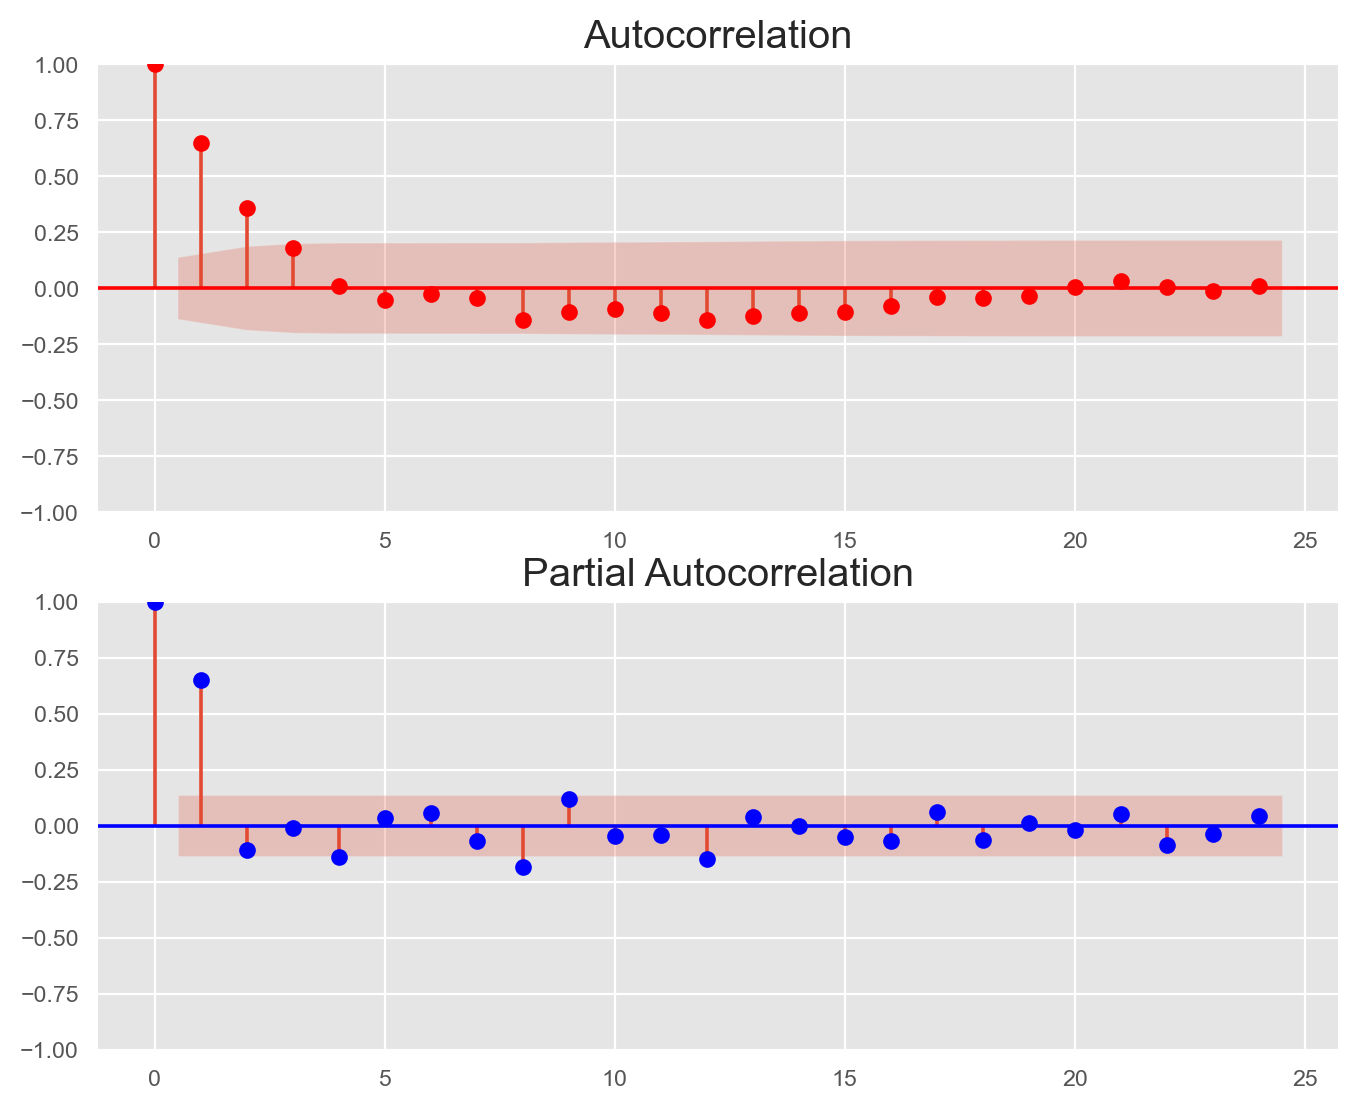

In [116]:
scale = 0.8
fig, axes = plt.subplots(2, 1, figsize=np.array([10, 8]) * scale)
tsaplots.plot_acf(diff.unemp, ax=axes[0], c="r")
tsaplots.plot_pacf(diff.unemp, ax=axes[1], c="b");

The ACF and PACF graphs suggest to chose p=3 and q=2 for ARIMA.
If I use non-auto ARIMA model the params defined above would serve as a first guess.
However, I'd use auto ARIMA to let the grid search to determine these params.
The only apriori param I'm missing is seasonality $m$, it can be determined from ACF plot, or Darts lib has a wrapper for this purpose, se below:

In [117]:
res = []
_range = range(2, 100, 1)
for m in _range:
    is_seasonal, period = check_seasonality(series, m=m, max_lag=_range[-1] + 2)
    res.append((is_seasonal, period))
res = pd.DataFrame(res, columns=["is_seasonal", "period"])
if res.is_seasonal.any():
    print(f"Suggested seasonality params are: {res.loc[res.is_seasonal]}")
else:
    print("No seasonality was found from ACF.")

No seasonality was found from ACF.


STL decomposition graph is for better visual understanding of seasonality.

Decomposition period is 4 [years]


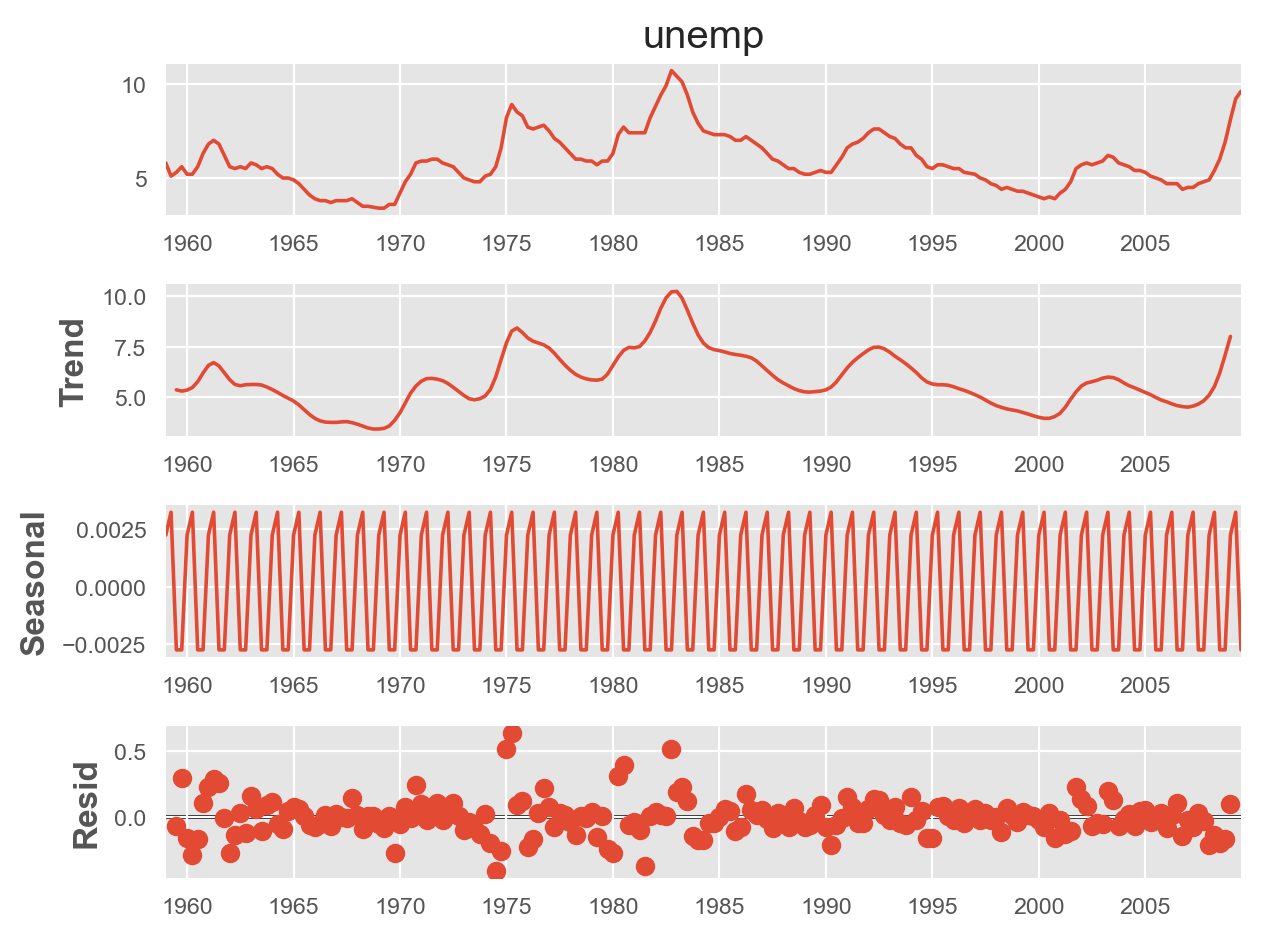

In [118]:
seasonality_order = 1  # years
step = 4  # step per year
period = int(seasonality_order * step)
result = seasonal_decompose(data.unemp, model="additive", period=period)
result.plot();
print(f"Decomposition period is {period} [years]")

In [119]:
# Setting up an experiment
# Helper funcs for the experiment
def train_test_split(
        series: Any,
        train_ratio: float = 0.8) -> Tuple[TimeSeries, Any]:
    if isinstance(series, pd.Series):
        series = pd.DataFrame(series)
    if not isinstance(series, TimeSeries):
        series = TimeSeries.from_dataframe(series)
    return series, *series.split_before(train_ratio)


def train_test_split_pandas(ser: pd.Series, split_before: dt.datetime):
    mask = (ser.index <= split_before)
    return (ser[mask],
            ser[ser.index >= split_before],
            np.round(mask.mean(), 2))


def preprocess(
        series: TimeSeries,
        transformer: Pipeline,
        train: TimeSeries,
        test: TimeSeries,
) -> Tuple[TimeSeries, TimeSeries, TimeSeries]:
    # Avoid fitting the transformer on the validation set.
    train_transformed = transformer.fit_transform(train)
    test_transformed, series_transformed = (transformer.transform(ser) for ser in (test, series))
    return series_transformed, train_transformed, test_transformed


def get_prediction(
        model: Any,
        pred_horizon: int,
        train_series: TimeSeries,
        predict_from: bool,
        num_samples: int) -> TimeSeries:
    if predict_from:
        return model.predict(n=pred_horizon, series=train_series, num_samples=num_samples)
    return model.predict(n=pred_horizon)


def evaluate_model(
        model: Any,
        train_series: TimeSeries,
        test_series: TimeSeries,
        pred_horizon: int,
        predict_from_train: bool = False,
        num_samples: int = 100,
        transformer: Pipeline = None,
        metrics: dict[str: darts.metrics] = None,
        plot: bool = True,
        n_digits: int = 2,
        plot_scale: float = 0.8
) -> Tuple[dict, TimeSeries, TimeSeries]:
    # Get prediction.
    pred_series = get_prediction(model, pred_horizon,
                                 train_series, predict_from_train, num_samples)
    # Inverse-transform TS if transformer was passed.
    if transformer is not None:
        train_series, test_series, pred_series = (
            transformer.inverse_transform(ser) for ser in
            (train_series, test_series, pred_series)
        )
    # Calculate metrics for back test and for test/validation.
    if metrics is None:
        metrics = dict(MSE=mse, MAPE=mape)
    metrics_test = {}
    for name, metric in metrics.items():
        metrics_test[name] = round(metric(pred_series, test_series), n_digits)
    # Plot results.
    if plot:
        plt.figure(figsize=np.array((8, 5)) * plot_scale)
        train_series.plot(label="train data")
        test_series.plot(label="test data")
        pred_series.plot(label="pred data")
        plt.legend()
        title = ""
        for name, metric in metrics_test.items():
            title += f" {name} = {metric} |"
        plt.title(title)
        plt.ylabel(train_series.columns[0])
        plt.xlabel(f"Time [{train_series.freq_str}]")
        plt.legend()
        plt.show()
    return metrics_test, pred_series, test_series


def evaluate_model_backtest(
        model: Any,
        series: TimeSeries,
        train_series: TimeSeries,
        test_series: TimeSeries,
        transformer: Pipeline = None,
        start: (float, dt.datetime) = 0.5,
        back_test_horizon: int = 4,
        metrics: dict[str: darts.metrics] = None,
        plot: bool = True,
        n_digits: int = 2,
        plot_scale: float = 0.8,
        **kwargs
) -> Tuple[dict, dict, pd.DataFrame]:
    # Get back test.
    backtest_series = model.historical_forecasts(
        series,
        start=start,
        forecast_horizon=back_test_horizon,
        verbose=False,
        last_points_only=True,
        **kwargs
    )
    # Inverse-transform TS if transformer was passed.
    if transformer is not None:
        series, train_series, test_series, backtest_series = (
            transformer.inverse_transform(ser) for ser in
            (series, train_series, test_series, backtest_series)
        )
    # Create DF with back test values.
    df = pd.concat([
        series.pd_series(),
        backtest_series.pd_series(),
        pd.Series(
            np.zeros(len(series)),
            index=series.time_index).astype(bool)],
        names=["data",  "back_test", "is_train"],
        axis=1)
    df.loc[df.index <= train_series.end_time(), "is_train"] = True
    # Calculate metrics for back test and for test/validation.
    if metrics is None:
        metrics = dict(MSE=mse, MAPE=mape)
    metrics_backtest, metrics_test = {}, {}
    for name, metric in metrics.items():
        metrics_backtest[name] = round(metric(series, backtest_series), n_digits)
        metrics_test[name] = round(metric(series, test_series), n_digits)
    # Plot results.
    if plot:
        plt.figure(figsize=np.array((8, 5)) * plot_scale)
        train_series.plot(label="train data")
        test_series.plot(label="test data")
        backtest_series.plot(label="back test")
        plt.legend()
        title = f"Backtest w horizon {back_test_horizon} time steps"
        for name, metric in metrics_backtest.items():
            title += f" | {name} = {metric}"
        title += " @ backtest"
        plt.title(title)
        plt.ylabel(series.columns[0])
        plt.xlabel(f"Time [{series.freq_str}]")
        plt.legend()
        plt.show()
    return metrics_test, metrics_backtest, df

In [120]:
# Train test split
_, train, test = train_test_split(series)

<a id="arima"></a>
# 4. Let's fire up auto ARIMA
#### and let it search for the best params

In [121]:
# Define D and d params by OCSB and CH tests
max_d = 5
max_seasonality = 60
n_diff = pm.arima.ndiffs(y, test='adf', max_d=max_d)
n_ocsb = pm.arima.OCSBTest(m=max(4, max_seasonality)).estimate_seasonal_differencing_term(y)
n_ch = pm.arima.CHTest(m=max(4, max_seasonality)).estimate_seasonal_differencing_term(y)
ns_diff = max(n_ocsb, n_ch)

In [122]:
arima = AutoARIMA(
    start_p=1,
    max_p=4,
    start_q=1,
    max_q=4,
    d=n_diff,
    max_d=n_diff,
    start_P=0,
    max_P=4,
    D=ns_diff,
    max_D=4,
    start_Q=0,
    max_Q=4,
    m=4,
    seasonal=True,
    max_order=5,
    stationary=True,
    information_criterion="bic",
    alpha=ALPHA,
    test="adf",
    seasonal_test="ocsb",
    stepwise=True,
    suppress_warnings=True,
    error_action="trace",
    trace=False,
    with_intercept="auto")
arima.fit(train);

Auto ARIMA evaluation on test


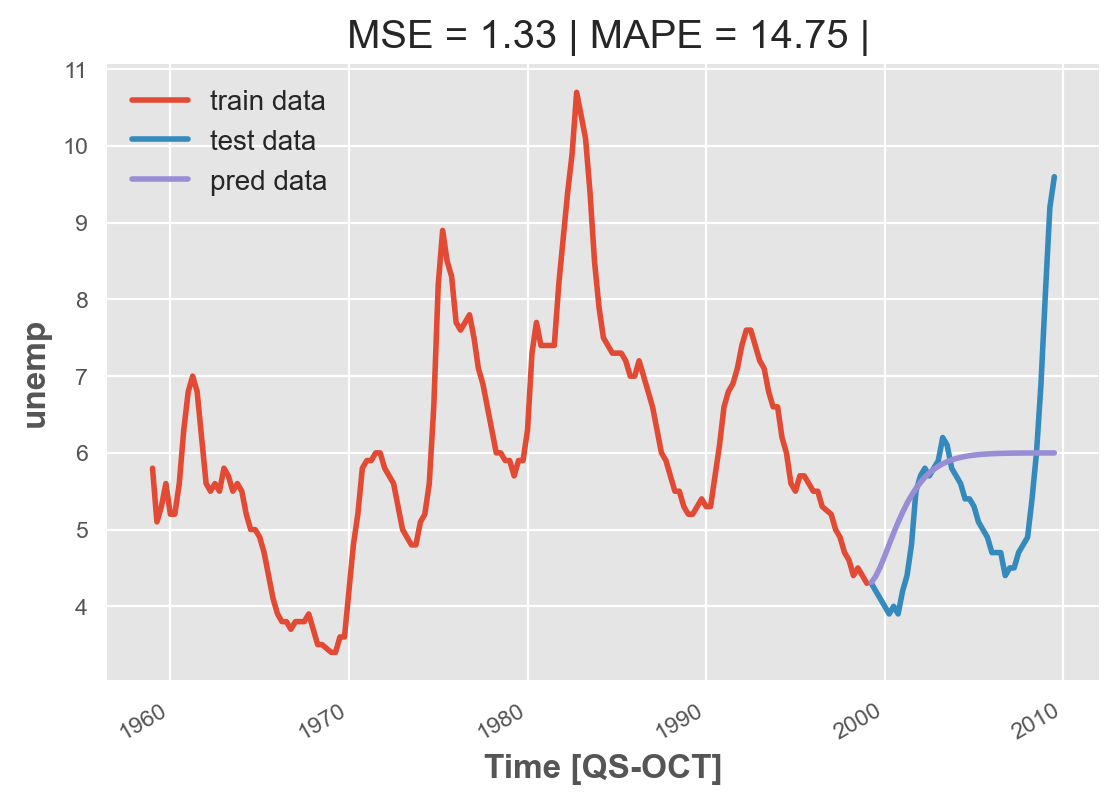

In [123]:
# Evaluate auto ARIMA.
print("Auto ARIMA evaluation on test")
_ = evaluate_model(
    arima,
    train,
    test,
    pred_horizon=len(test)
)

The resulted ARIMA has performs very poor on a test sample. I'll try to add some data transformation (as it comes from previous TS distribution analysis), like Box-Cox transformation.

Also, I have idea to simply remove last spike from the data as it could create bias in the model's weights.
So the data looks like:

In [124]:
# remove last part of data
data_sel = data.loc[data.index <= dt.datetime(2008, 5, 1)]
# data_sel = data.copy()
_, train, test = train_test_split(data_sel.unemp)
trace_all = go.Scatter(x=data_sel.index, y=data_sel.unemp, name="all data")
trace_train = go.Scatter(x=train.pd_series().index, y=train.pd_series().values, name="train data")
trace_test = go.Scatter(x=test.pd_series().index, y=test.pd_series().values, name="test data")
fig = go.Figure(
    [trace_all] + [trace_train] + [trace_test],
    layout=go.Layout(dict(
        template="ggplot2",
        title="Sliced unemployment data",
        xaxis_title="Time [3M]",
        yaxis_title="Unemployment [%]",)
    ))
fig.show()

#### Auto Arima pipeline with Box-Cox transformation

Auto ARIMA with Box-Cox transformation evaluation on test


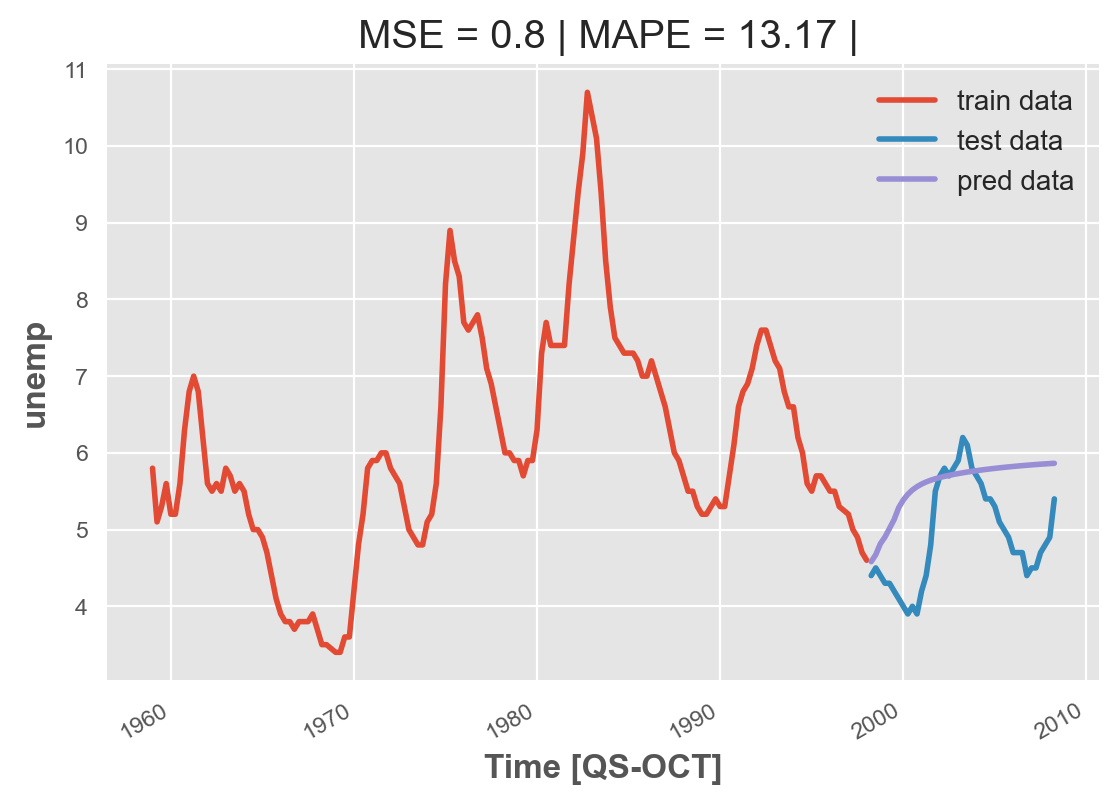

In [125]:
transformer = Pipeline([
    Scaler(PowerTransformer("box-cox"), "Boc-Cox")
])
series_box, train_box, test_box = preprocess(
    series, transformer, train, test)
arima.fit(train_box)
print("Auto ARIMA with Box-Cox transformation evaluation on test")
_ = evaluate_model(
    arima,
    train_box,
    test_box,
    pred_horizon=len(test_box),
    transformer=transformer
)

The resulted pipeline performs pretty much same.
It's a very strange behaviour of the model and maybe I'm mistaken with params or initialization, so it needs more detailed investigation.

Form here, I will either work better with ARIMA params and transformations (some stacking of several models, etc.) or choose another model.
I'll go for second option and also will introduce some pipline automation with MLFlow.

---

<a id="rnn"></a>
# 5. RNN approach

One would need to scale inputs to the DL-based model, as linear transformation of NN benefits from normal data distribution.

Next I define some first guess params of RNN, later those params I'm going to put in the config and automate experimenting (refer to p.3 in README.md)

In [126]:
quantiles = np.arange(0.1, 1, 0.1)
quantiles = [0.05] + [round(q, 2) for q in quantiles.tolist()] + [.95]

In [127]:
# @hide_cell
transformer = Pipeline([
    Scaler(StandardScaler(), "StandardScaler")
])
series_scaled, train_scaled, test_scaled = preprocess(
    series, transformer, train, test)
rnn = RNNModel(
    model="LSTM",
    input_chunk_length=58,
    hidden_dim=20,
    dropout=0.2,
    batch_size=16,
    n_epochs=200,
    optimizer_kwargs={"lr": 3e-4},  # Karpathy const for Adam as initial guess
    random_state=RND_STATE,
    training_length=12,
    log_tensorboard=True,
    likelihood=GaussianLikelihood(),
)
# Train RNN.
rnn.fit(
    train_scaled,
    verbose=False
);

2022-09-08 01:03:46 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-09-08 01:03:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-08 01:03:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-08 01:03:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-08 01:04:01 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=200` reached.


RNN evaluation on test


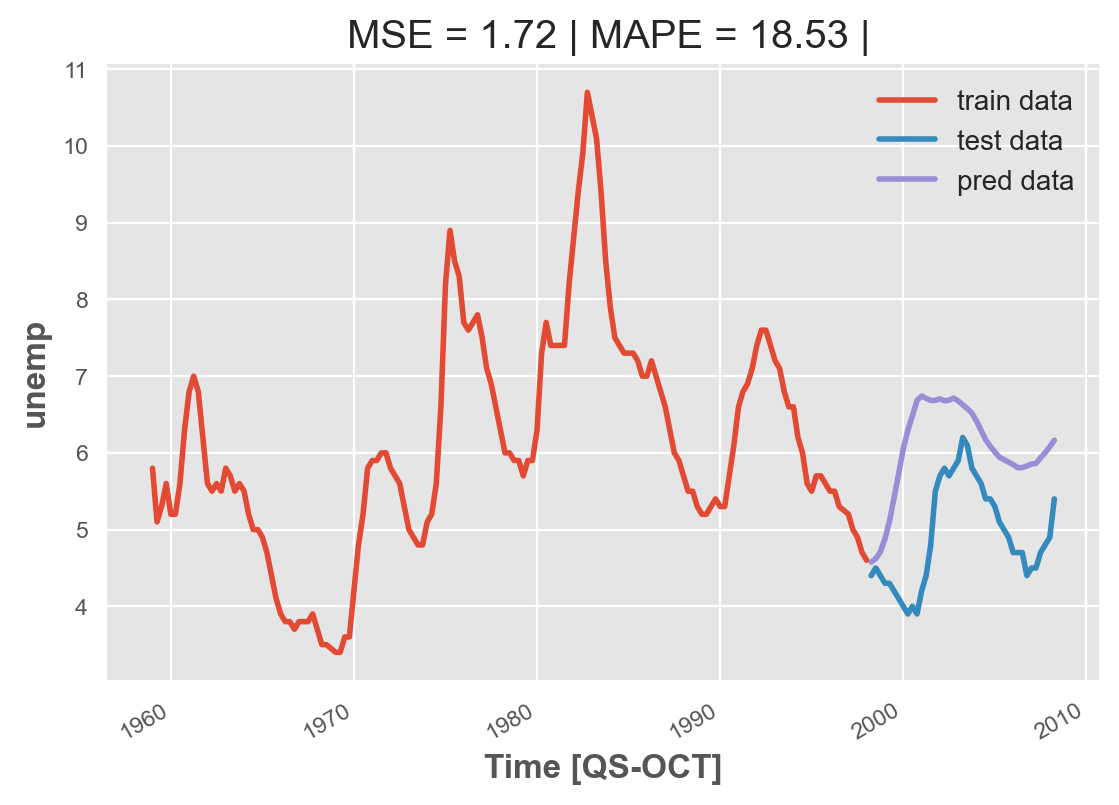

In [128]:
# Evaluate RNN on test sample.
print("RNN evaluation on test")
_, pred, _ = evaluate_model(
    rnn,
    train_scaled,
    test_scaled,
    pred_horizon=len(test_scaled),
    transformer=transformer
)

The RNN model performs better, so I'll continue with hyper params search and experiment automation.

#### Hyperparameters estimation
As it takes way too much time to make a grid search of hyperparameters of RNN, I will leave only code/idea of how to proceed, but do not actually execute it on a local machine with no GPU. It rather requires GPU, e.g. Google Colab or some other cloud environment.
Also, there's no risk of training models on the cloud as the data is public.

---

The work with RNN parameters setting is implemented as an experiment pipeline, refer to [README.md](../README.md) for more details on how to execute the experiment.

In [129]:
# Hyper params search.
params = {
    "input_chunk_length": np.arange(20, 60, 10),
    "hidden_dim": np.arange(10, 33, 4),
    "dropout": [0.1, 0.2],
    "batch_size": [16, 32],
    "n_epochs": 300
}
# best_model, best_params, best_score = rnn.gridsearch(
#     params,
#     series_scaled,
#     forecast_horizon=4,
#     metric=mse,
#     start=0.5,
#     n_jobs=-1
# )

Let us check whether there is a correlation between target and the rest of features with correlation plot.

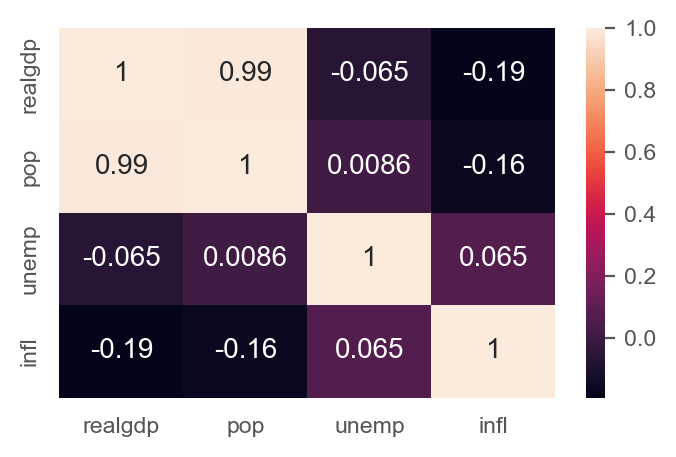

In [130]:
scale = 0.4
plt.figure(figsize=np.array([10, 6]) * scale)
sns.heatmap(data.corr(), annot=True);

As there is no strong correlation between unemployment rate and other features, so adding these features to the model will not help a lot (my first guess).

But I would leave this for N-BEATS model or for further possible improvements, as there's a nice feature of Darts allowing to easy make feature extraction from time series and correlated time series as well -- [covariates](https://unit8co.github.io/darts/userguide/covariates.html).

<a id="nbeats"></a>
# 6. N-BEATS model
Last but not least I'd like to investigate [N-BEATS](https://openreview.net/pdf?id=r1ecqn4YwB) model performance ([Darts reference](https://github.com/unit8co/darts/blob/master/examples/07-NBEATS-examples.ipynb)).

There's also an option to use pre-trained NBEATS on M3 and M4 datasets and execute zero-shot prediction (a.k.a. transfer-learning), but I'll also leave it as a possible option for further improvement ([Darts reference](https://github.com/unit8co/darts/blob/master/examples/14-transfer-learning.ipynb)).

---

I've fitted N-BEATS model on GPU in Colab and saved [notebook](./nbeats.ipynb).
I've also resampled unemployment data to 1M resolution by linear interpolation to see if it can improve prediction
(also 1M is a natural timestamp resolution for this type of data).
Data was restored for original length as well.
Further, I'm going to present forecast results and answer the task question.

<a id="forecast"></a>
# 6. Final forecast

In [131]:
# Define forecast timestamps.
pred_series = pd.date_range(
    start=data.index.max(),
    end=PRED_TIME,
    freq="1M")[1:]
# pred_series = pred_series.map(lambda x: x.replace(day=1))
HORIZON = pred_series.shape[0]

#### Evaluation of N-BEATS for unemployment from [Colab notebook](./nbeats.ipynb)

In [132]:
# @hide_cell
alpha_plot = 0.2

In [133]:
# Read results from models fits from Colab.
files = ("df_pop.csv", "df_pop_test.csv", "df_unemp.csv", "df_unemp_test.csv")
df_pop, df_pop_test, df_unemp, df_unemp_test = (
    pd.read_csv(
        os.path.join(DATA_DIR, "results", file),
        index_col=["Period"],
        parse_dates=["Period"],
        date_parser=lambda x: pd.to_datetime(x, format=DT_FORMAT)
    )
    for file in files
)

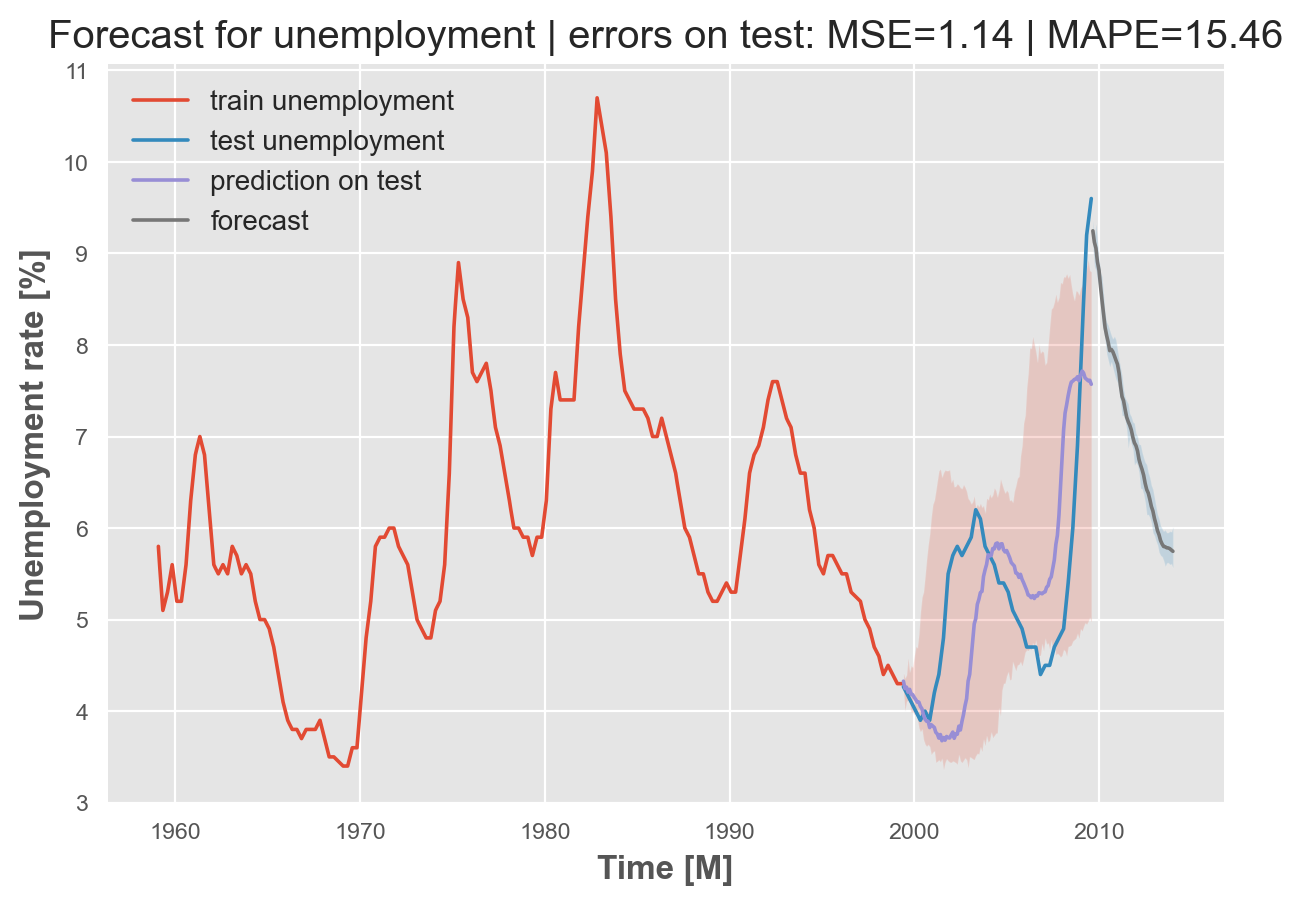

In [134]:
plot_scale = 0.6
df = df_unemp_test.copy()
name = "unemployment"
plt.figure(figsize=np.array((12, 8)) * plot_scale)
plt.plot(df.index, df[f"{name}_train"], label=f"train {name}")
plt.plot(df.index, df[f"{name}_test"], label=f"test {name}")
plt.plot(df.index, df["mean"], label="prediction on test")
plt.fill_between(df.index, df["low"], df["high"], alpha=0.2)
df_sel = df[~df["mean"].isna()]
mse_err = mean_squared_error(df_sel[f"{name}_test"], df_sel["mean"])
mape_err = mean_absolute_percentage_error(df_sel[f"{name}_test"], df_sel["mean"]) * 100

df = df_unemp.copy()
plt.plot(df.index, df["mean"], label="forecast")
plt.fill_between(df.index, df["low"], df["high"], alpha=alpha_plot)
plt.xlabel("Time [M]")
plt.ylabel("Unemployment rate [%]")
plt.title(f"Forecast for {name} | errors on test: MSE={mse_err:.2f} | MAPE={mape_err:.2f}")
plt.legend();

As it can be seen from the graph above N-BEATS model predicts unemployment better that all previous models fitted in the notebook. It resulted in the following errors on the test sample:
- $ MSE = 1.16 $
- $ MAPE = 15.6 $

#### Evaluation of LinearRegression for population

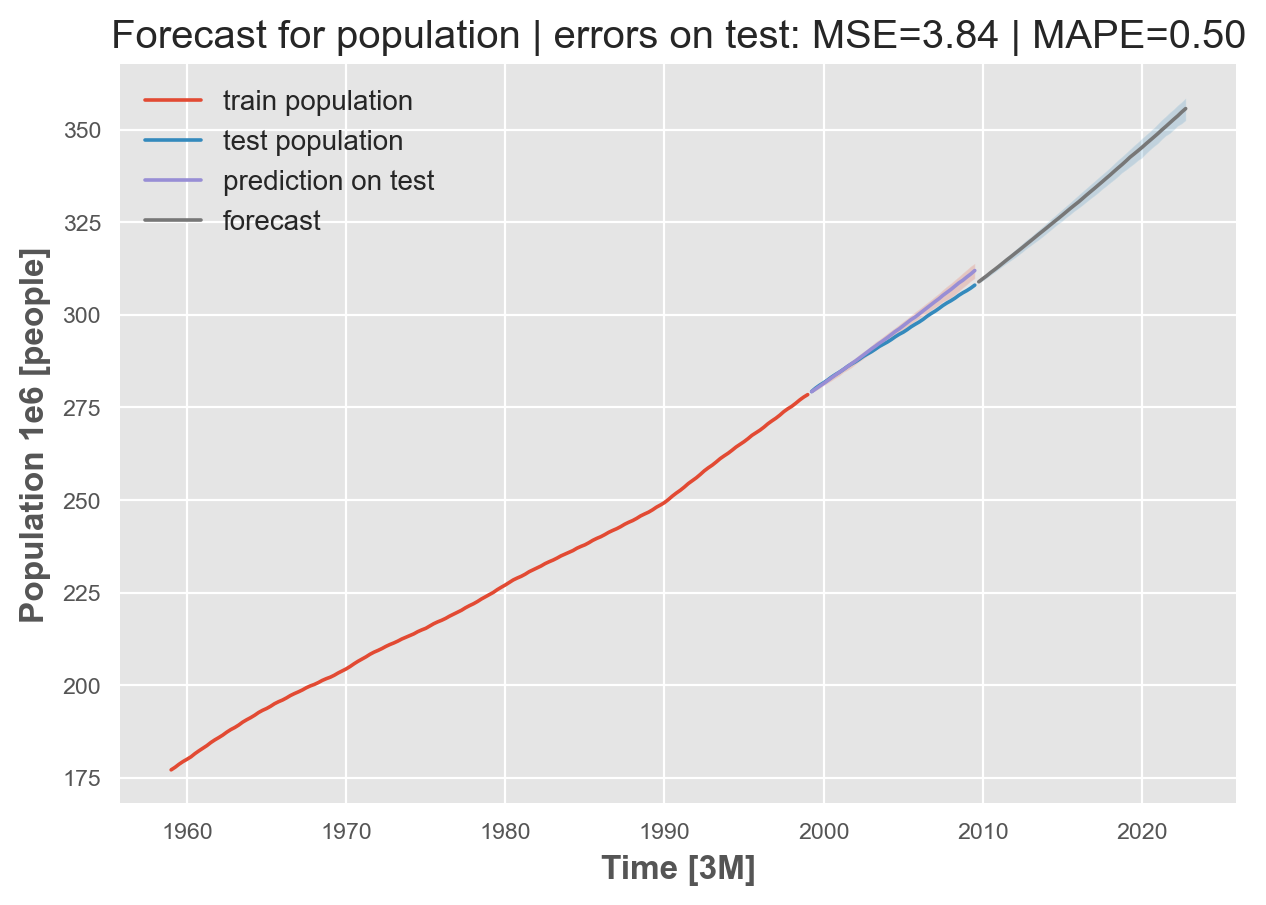

In [135]:
plot_scale = 0.6
df = df_pop_test.copy()
name = "population"
plt.figure(figsize=np.array((12, 8)) * plot_scale)
plt.plot(df.index, df[f"{name}_train"], label=f"train {name}")
plt.plot(df.index, df[f"{name}_test"], label=f"test {name}")
plt.plot(df.index, df["mean"], label="prediction on test")
plt.fill_between(df.index, df["low"], df["high"], alpha=alpha_plot)
df_sel = df[~df["mean"].isna()]
mse_err = mean_squared_error(df_sel[f"{name}_test"], df_sel["mean"])
mape_err = mean_absolute_percentage_error(df_sel[f"{name}_test"], df_sel["mean"]) * 100

df = df_pop.copy()
plt.plot(df.index, df["mean"], label="forecast")
plt.fill_between(df.index, df["low"], df["high"], alpha=0.2)
plt.xlabel("Time [3M]")
plt.ylabel("Population 1e6 [people]")
plt.title(f"Forecast for {name} | errors on test: MSE={mse_err:.2f} | MAPE={mape_err:.2f}")
plt.legend();

Linear regression predicts well population data as expected. So the errors in test are:
- $ MSE = 3.84 $
- $ MAPE = 0.5 $

<a id="answ"></a>
# 6. Answers to the tasks
As I made a probabilistic forecast, so I'll answer with confidence level of 95%.

1. As for the unemployment rate forecast I've resulted in the following values for Q4 2013.

In [136]:
row = df_unemp.loc[
    (df_unemp.index >= dt.datetime(2013, 10, 1)) &
    (df_unemp.index < dt.datetime(2014, 1, 1))].mean().round(2)
unemp_mean, unemp_min, unemp_high = row["mean"], row.low, row.high
print("The unemployment rate in Q4 2013 "
      f"will be in the range of [{unemp_min}, {unemp_high}] [%] \n"
      "with 95% confidence level, "
      f"with the mean value of {unemp_mean} [%].")

The unemployment rate in Q4 2013 will be in the range of [5.59, 5.98] [%] 
with 95% confidence level, with the mean value of 5.76 [%].


2. As for the unemployed people in 2013.

In [137]:
employ_ratio = 0.65  # of the population is considered to be in the labor force at all times
start_dt, stop_dt = dt.datetime(2013, 1, 1), dt.datetime(2013, 12, 31)
df_pop_2013 = df_pop.loc[
    (df_pop.index >= start_dt) &
    (df_pop.index <= stop_dt)].mean() * employ_ratio
df_unemp_2013 = df_unemp.loc[
    (df_unemp.index >= start_dt) &
    (df_unemp.index <= stop_dt)].mean()

In [138]:
low_value = (df_unemp_2013.low * df_pop_2013.low) / 100
high_value = (df_unemp_2013.high * df_pop_2013.high) / 100
mean_value = (df_unemp_2013["mean"] * df_pop_2013["mean"]) / 100
low_value, mean_value, high_value = (
    np.round(val, 2) for val in (low_value, mean_value, high_value))
print("Number of unemployed people in 2013 on average "
      f"will be in the range of [{low_value}, {high_value}]*1e6 [people] \n"
      "with 95% confidence level, "
      f"with the mean value of {mean_value:.2f}*1e6 [people].")

Number of unemployed people in 2013 on average will be in the range of [11.79, 12.63]*1e6 [people] 
with 95% confidence level, with the mean value of 12.19*1e6 [people].


---

#### Read monthly unemployment data found on the [web](https://fred.stlouisfed.org/series/UNRATE/) to compare forecast with real data

In [139]:
df = pd.read_excel(
    os.path.join(DATA_EXT, "SeriesReport-20220901054745_3fc598.xlsx"),
    skiprows=11)
data_parsed = []
for index, row in df.iterrows():
    year = int(row[0])
    for value, month in zip(row[1:], range(1, 13)):
        date = dt.date(year, month, 1)
        data_parsed.append((date, float(value)))
data_parsed = np.array(data_parsed)
data_monthly = pd.DataFrame(
    data_parsed[:, 1], index=data_parsed[:, 0], columns=["unemp"])
data_monthly.index = pd.to_datetime(data_monthly.index, format=DT_FORMAT)
data_monthly.dropna(subset=["unemp"], inplace=True)
data_monthly_3m = data_monthly.resample("3M").mean()
data_monthly_3m.index = data_monthly_3m.index.map(lambda x: x.replace(day=1))

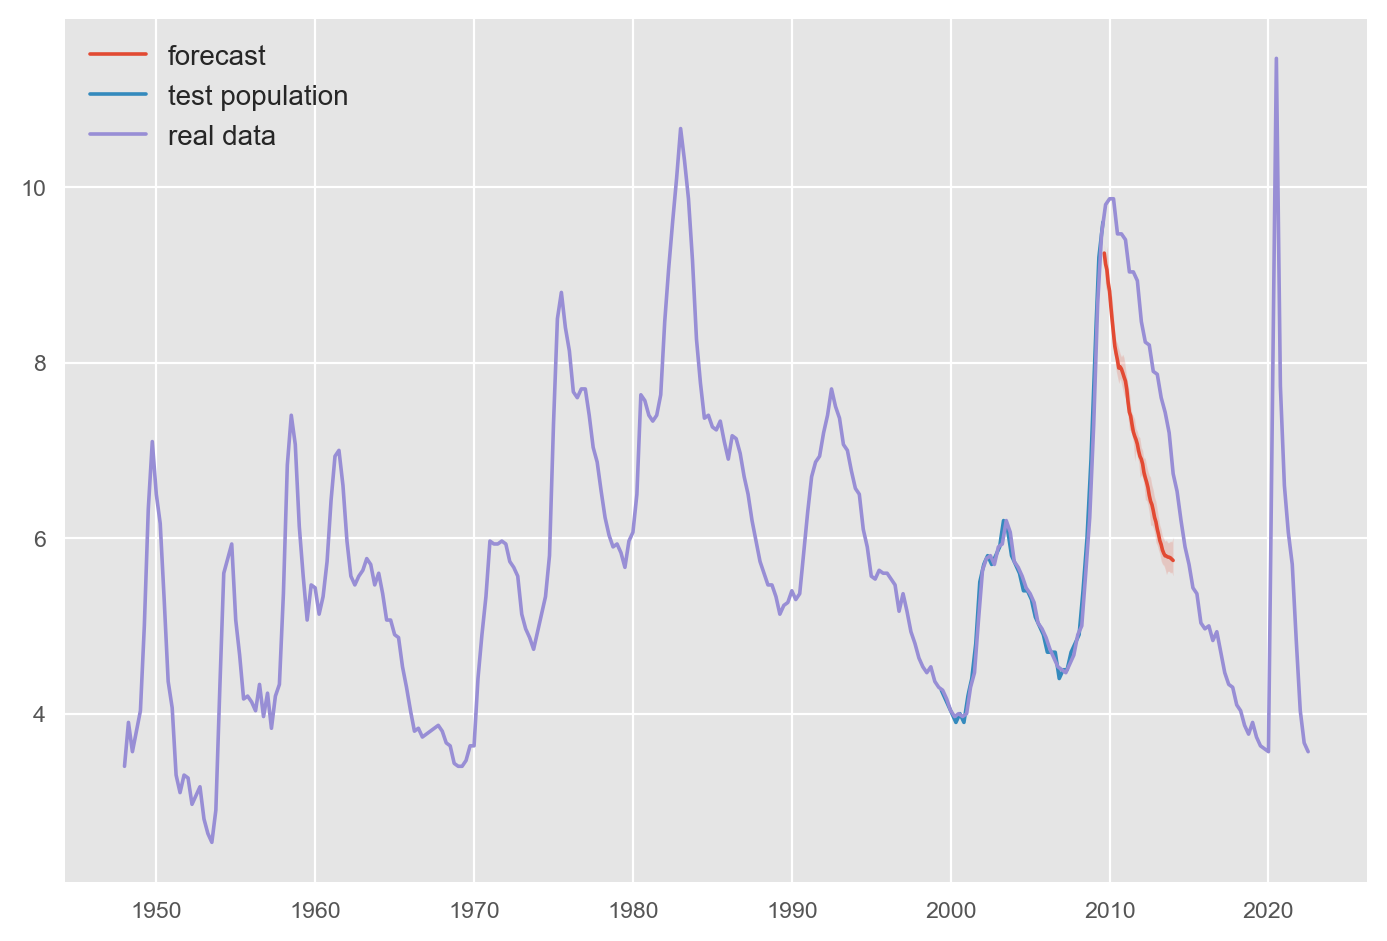

In [140]:
plot_scale = 0.7
plt.figure(figsize=np.array((12, 8)) * plot_scale)
plt.plot(df_unemp.index, df_unemp["mean"], label="forecast")
plt.fill_between(df_unemp.index, df_unemp["low"], df_unemp["high"], alpha=alpha_plot)
plt.plot(df_unemp_test.index, df_unemp_test["unemployment_test"], label=f"test {name}")
plt.plot(data_monthly_3m.index, data_monthly_3m.unemp, label="real data")
plt.legend();

<a id="conclusion"></a>
# 7. Conclusion

The timeseries is not very easy to predict, due to different cycles and patterns.
ARIMA model as a baseline was applied, then RNN with whole pipeline for automated experiment was set up (README.md p.3).
The best prediction though was obtained by employing N-BEATS model trained in the Colab and separate [notebook](./nbeats.ipynb).
The forecast by N-BEATS model is pretty close to reality/future.
However, different ideas can be implemented for further model improvement such as:
- feature engineering: using covariates, investigating new features, extracting different timseries features (month-, year-based) some other data source in economy
- hyperparameter optimization of the final model
- trying different train/test splits to obtain representative samples respectively
- better investigation of timeseries components and maybe try separate models for the components
- stacking different models